In [1]:
# Импорт библиотек
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score
import joblib
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
import random

In [2]:
# 1. Загрузка данных
df = pd.read_csv("/Users/theother_archee/PycharmProjects/Project_ML_Course/synthetic_dataset_generation/synthetic_users_data.csv")

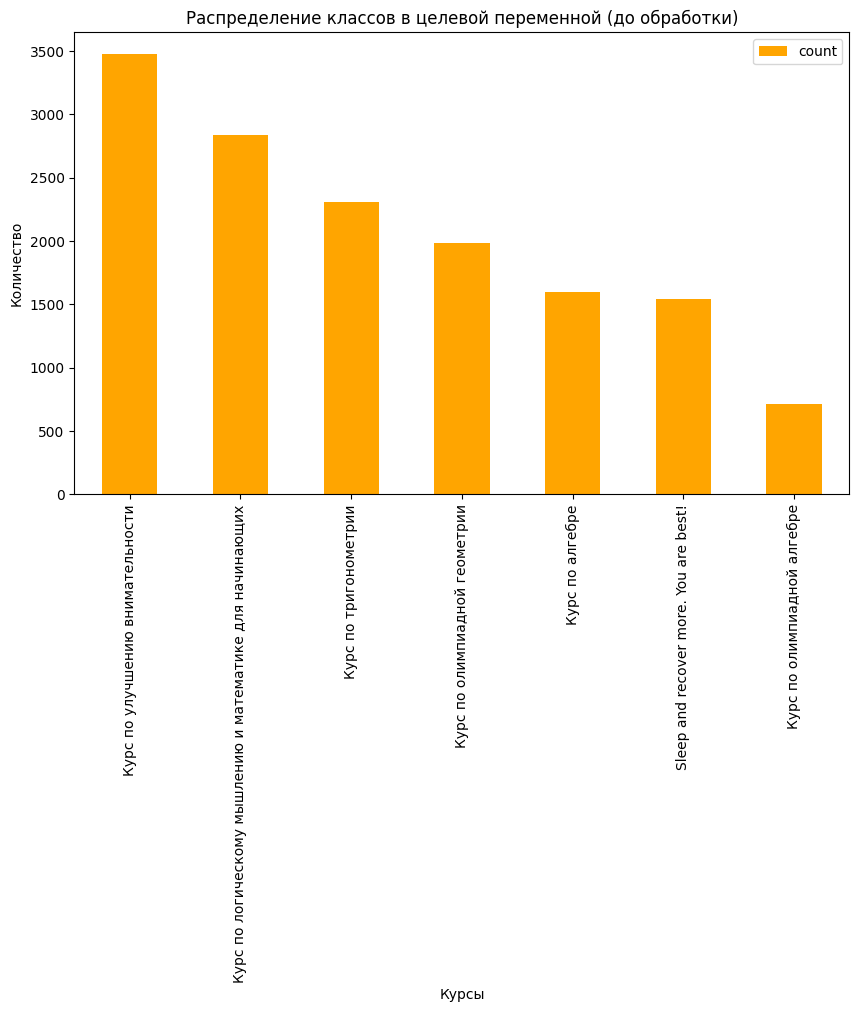

Распределение классов до обработки:
                                                    count
Курс по улучшению внимательности                     3473
Курс по логическому мышлению и математике для н...   2838
Курс по тригонометрии                                2304
Курс по олимпиадной геометрии                        1985
Курс по алгебре                                      1596
Sleep and recover more. You are best!                1543
Курс по олимпиадной алгебре                           715


In [3]:
# Шаг 2: Изучение данных
# Разделяем строку с рекомендациями на список курсов
df['course_recommend'] = df['course_recommend'].apply(lambda x: x.split(", "))

# Считаем количество упоминаний каждого курса
class_counts = Counter([course for courses in df['course_recommend'] for course in courses])

# Преобразуем в DataFrame для удобного отображения
class_distribution = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count']).sort_values(by='count', ascending=False)

# Визуализация распределения классов
class_distribution.plot(kind='bar', figsize=(10, 6), color="orange")
plt.title("Распределение классов в целевой переменной (до обработки)")
plt.xlabel("Курсы")
plt.ylabel("Количество")
plt.show()

# Вывод распределения классов
print("Распределение классов до обработки:")
print(class_distribution)

In [4]:
df

,user_id,total_questions,total_correct_solutions,number_algebra_mistakes,number_trigonometry_mistakes,number_reading_mistakes,number_working_with_formulas_mistakes,course_recommend
0,1,38,15,4,33,1,3,[Курс по тригонометрии]
1,2,23,14,14,1,1,1,[Курс по олимпиадной геометрии]
2,3,12,4,4,3,1,0,[Sleep and recover more. You are best!]
3,4,44,43,0,1,0,0,[Sleep and recover more. You are best!]
4,5,22,4,4,23,0,0,[Курс по тригонометрии]
...,...,...,...,...,...,...,...,...
9995,9996,5,0,1,4,0,0,[Курс по тригонометрии]
9996,9997,33,32,0,0,0,1,[Sleep and recover more. You are best!]
9997,9998,18,16,0,1,0,1,"[Курс по олимпиадной геометрии, Курс по логиче..."
9998,9999,50,15,0,29,28,7,"[Курс по тригонометрии, Курс по улучшению вним..."


In [5]:
# Шаг 3: Преобразование целевой переменной (Multi-Label Encoding)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['course_recommend'])

In [6]:
# Шаг 4: Подготовка признаков (X)
# Убираем ненужные колонки
X = df.drop(columns=["user_id", "course_recommend"], axis=1)

# Нормализация данных (масштабирование)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Сохранение scaler
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

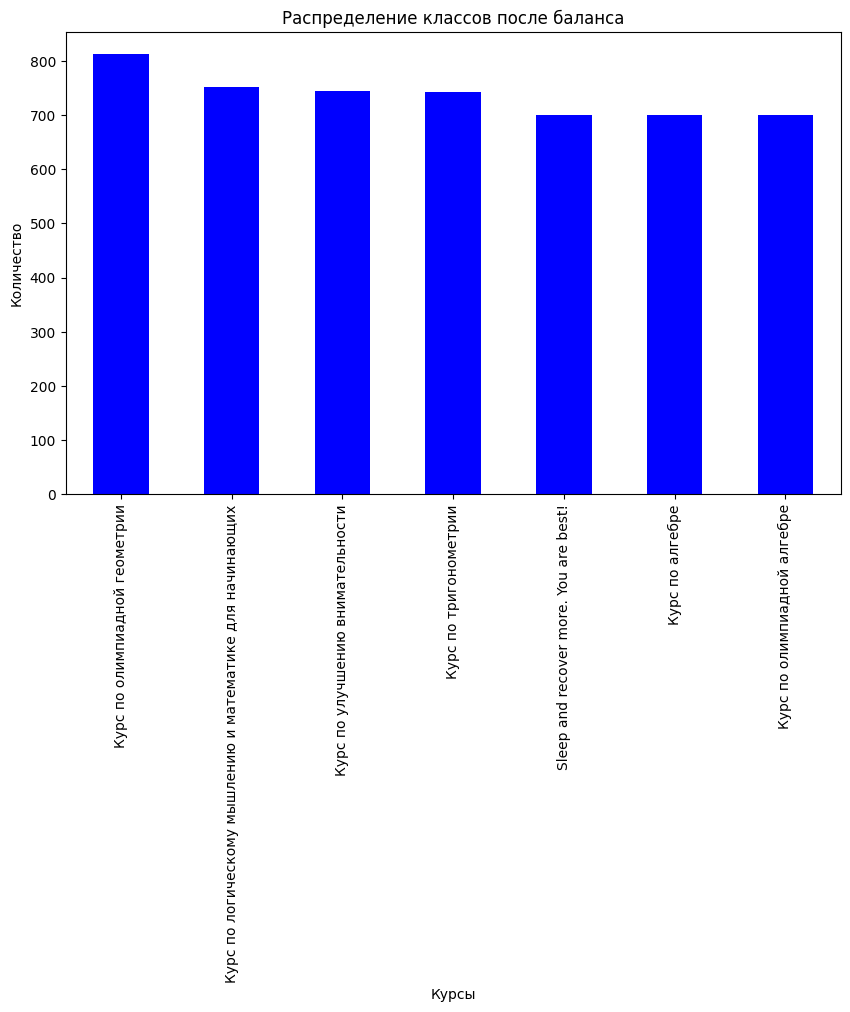

Распределение классов после баланса:
Курс по олимпиадной геометрии                               812
Курс по логическому мышлению и математике для начинающих    751
Курс по улучшению внимательности                            744
Курс по тригонометрии                                       742
Sleep and recover more. You are best!                       700
Курс по алгебре                                             700
Курс по олимпиадной алгебре                                 700
dtype: int64


In [8]:
# Шаг 5: Удаление избыточных данных (undersampling)
# Устанавливаем целевой минимум для каждого класса
def balance_classes(X, y, max_samples_per_class):
    """
    Балансировка классов с использованием undersampling и oversampling.
    :param X: Признаки (numpy array или DataFrame)
    :param y: Многометочная целевая переменная (numpy array)
    :param max_samples_per_class: Максимальное количество строк на класс
    :return: Сбалансированные X и y
    """
    selected_indices = set()
    class_counts = {i: 0 for i in range(y.shape[1])}  # Счётчик строк для каждого класса
    X_balanced = []
    y_balanced = []

    # Перебираем строки
    for idx in range(y.shape[0]):
        active_classes = np.where(y[idx] == 1)[0]
        if all(class_counts[class_idx] < max_samples_per_class for class_idx in active_classes):
            selected_indices.add(idx)
            for class_idx in active_classes:
                class_counts[class_idx] += 1

    # Преобразуем в список индексов
    selected_indices = list(selected_indices)
    X_selected = X[selected_indices]
    y_selected = y[selected_indices]

    # Oversampling для недостающих классов
    for class_idx in range(y.shape[1]):
        current_class_indices = np.where(y_selected[:, class_idx] == 1)[0]
        if len(current_class_indices) < max_samples_per_class:
            # Сколько строк нужно добавить
            additional_samples_needed = max_samples_per_class - len(current_class_indices)
            if additional_samples_needed > 0:
                # Повторяем строки, чтобы добавить недостающие
                X_to_add, y_to_add = resample(
                    X_selected[current_class_indices],
                    y_selected[current_class_indices],
                    replace=True,
                    n_samples=additional_samples_needed,
                    random_state=42
                )
                X_balanced.append(X_to_add)
                y_balanced.append(y_to_add)

    # Объединяем всё
    X_balanced = np.vstack([X_selected] + X_balanced)
    y_balanced = np.vstack([y_selected] + y_balanced)

    return X_balanced, y_balanced

# Применяем функцию
max_samples_per_class = 700
X_final, y_final = balance_classes(X_scaled, y, max_samples_per_class)

# Проверяем распределение
final_class_counts = pd.DataFrame(y_final, columns=mlb.classes_).sum().sort_values(ascending=False)
final_class_counts.plot(kind="bar", figsize=(10, 6), color="blue")
plt.title("Распределение классов после баланса")
plt.xlabel("Курсы")
plt.ylabel("Количество")
plt.show()

print("Распределение классов после баланса:")
print(final_class_counts)

In [9]:
# Шаг 6: Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
# Шаг 7: Определение моделей и гиперпараметров
param_grid = {
    'RandomForest': {
        'model': MultiOutputClassifier(RandomForestClassifier(random_state=42)),
        'params': {
            'estimator__n_estimators': [50, 100, 150],
            'estimator__max_depth': [10, 20, None],
            'estimator__min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': MultiOutputClassifier(GradientBoostingClassifier(random_state=42)),
        'params': {
            'estimator__n_estimators': [50, 100],
            'estimator__learning_rate': [0.01, 0.1, 0.2],
            'estimator__max_depth': [3, 5, 7]
        }
    },
    'LogisticRegression': {
        'model': MultiOutputClassifier(LogisticRegression(max_iter=500, random_state=42)),
        'params': {
            'estimator__C': [0.1, 1, 10],
            'estimator__penalty': ['l2'],
            'estimator__solver': ['lbfgs']
        }
    },
    'KNeighbors': {
        'model': MultiOutputClassifier(KNeighborsClassifier()),
        'params': {
            'estimator__n_neighbors': [3, 5, 7, 9],
            'estimator__weights': ['uniform', 'distance'],
            'estimator__metric': ['euclidean', 'manhattan']
        }
    }
}

In [11]:
# Перебор моделей и гиперпараметров, включая KNeighborsClassifier
best_model = None
best_score = 0
best_model_name = None

for model_name, model_data in param_grid.items():
    print(f"Тестируем {model_name}...")
    grid_search = GridSearchCV(model_data['model'], model_data['params'], cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Лучшие параметры для {model_name}: {grid_search.best_params_}")
    print(f"Точность для {model_name}: {grid_search.best_score_:.2f}")
    
    if grid_search.best_score_ > best_score:
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_
        best_model_name = model_name

Тестируем RandomForest...
Лучшие параметры для RandomForest: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 150}
Точность для RandomForest: 0.63
Тестируем GradientBoosting...
Лучшие параметры для GradientBoosting: {'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 100}
Точность для GradientBoosting: 0.65
Тестируем LogisticRegression...
Лучшие параметры для LogisticRegression: {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
Точность для LogisticRegression: 0.56
Тестируем KNeighbors...
Лучшие параметры для KNeighbors: {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 7, 'estimator__weights': 'distance'}
Точность для KNeighbors: 0.60


In [12]:
# Сохранение лучшей модели
joblib.dump(best_model, "best_model.pkl")
print(f"Лучшая модель: {best_model_name} с точностью {best_score:.2f}")

Лучшая модель: GradientBoosting с точностью 0.65
